In [2]:
import re
import pandas as pd
import requests
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import requests 
from bs4 import BeautifulSoup
import sqlite3
import html5lib
import datetime

import seaborn as sb
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000) 
pd.set_option('max_colwidth',2000)
from IPython.core.display import HTML
HTML("<style>.container { width:80% !important; }</style>")

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ImportError: No module named 'bs4'

## Get the HTML and convert into BeautifulSoup

In [2]:
url = 'https://www.kaggle.com/c/grupo-bimbo-inventory-demand/leaderboard'
request_raw = requests.request(method = 'GET', url = url)
request_text = request_raw.text
request_soup = BeautifulSoup(request_text, "lxml")

## Find the leaderboard table in the html

In [3]:
leaderboard_table_html = request_soup.find('table', attrs={'id':'leaderboard-table'})

## Mine the BeautifulSoup and create a DataFrame with the entries

In [4]:
entries = {}
for index, row in enumerate(leaderboard_table_html.findAll('tr')): 
    if(index == 0): continue 
    if('class' in row.attrs): continue
    row_dict = {}
    row_dict['id'] = row.attrs['id']
    row_dict['leader-number'] = int(row.find('td',attrs = {'class':'leader-number'}).string)
    row_dict['delta'] = row.find('td', attrs = {'class':'delta'}).find('span').string
    
    a_single_player = row.find('a', attrs = {'class':'team-link single-player'})
    if(a_single_player is not None):
        row_dict['team_link'] = a_single_player.attrs['href']
        row_dict['team_name'] = a_single_player.string.strip()
    
    a_team_player = row.find('a', attrs = {'class':'team-link team-player'})
    if(a_team_player is not None):
        row_dict['team_link'] = a_team_player.attrs['href']
        row_dict['team_name'] = a_team_player.string.strip() 
    
    row_dict['score_title'] = row.find('abbr', attrs = {'class':'score'}).attrs['title']
    row_dict['score'] = float(row.find('abbr', attrs = {'class':'score'}).string)
    row_dict['number_of_submissions'] = int(row.findAll('td')[4].string)
    # Best and last submission some regex cleanup to do
    temp = row.find('abbr', attrs = {'title':re.compile('Best Submission')}).attrs['title']
    row_dict['last_submission'] = re.split(pattern = '\n', string = temp)[0]
    row_dict['last_submission'] = re.sub(pattern = '.*Submission: ', repl = '', string =  row_dict['last_submission'])
    row_dict['last_submission'] = re.sub(pattern = '\(.*\)', repl = '', string =  row_dict['last_submission']).strip()
    row_dict['last_submission'] = re.sub(pattern = '[A-Za-z]*, ', repl = '', string =  row_dict['last_submission']).strip()        
    row_dict['best_submission'] = re.split(pattern = '\n', string = temp)[1]
    row_dict['best_submission'] = re.sub(pattern = '.*Submission: ', repl='', string = row_dict['best_submission'])
    row_dict['best_submission'] = re.sub(pattern = '\(.*\)', repl = '', string =  row_dict['best_submission']).strip()
    row_dict['best_submission'] = re.sub(pattern = '[A-Za-z]*, ', repl = '', string =  row_dict['best_submission']).strip()
    entries[index] = row_dict
entries = pd.DataFrame.from_dict(entries, orient = 'index')
entries.tail()

,score_title,score,number_of_submissions,leader-number,team_link,last_submission,best_submission,team_name,delta,id
860,5d improvement: none,1.38003,2,859,/onkwocha,28 Jun 2016 07:03:07,28 Jun 2016 07:03:07,NU_pdt ON,new,team-344380
861,5d improvement: none,1.49844,1,860,/abhisheksrathore,13 Jun 2016 11:00:55,13 Jun 2016 11:00:55,Abhishek,↓123,team-339401
862,5d improvement: none,3.50767,2,861,/ruimachado,28 Jun 2016 14:46:48,28 Jun 2016 14:38:40,RuiMachado,new,team-345022
863,5d improvement: none,6.07175,1,862,/sergioperez,21 Jun 2016 18:49:20,21 Jun 2016 18:49:20,SergioPerez,↓123,team-342861
864,5d improvement: none,7.77332,1,863,/lcsbny,19 Jun 2016 15:40:10,19 Jun 2016 15:40:10,lcsbny,↓123,team-337061


## Add the date_scraped and store into the Sqlite

In [5]:
entries['date_scraped'] = datetime.datetime.today()
conn = sqlite3.connect('Kaggle_Bimbo_results.db')
entries.to_sql(con = conn, name = 'Kaggle_Bimbo_Ranking', if_exists='append')

# Plot today

In [6]:
entries.loc[entries['team_name'] == 'Kasper Van Lombeek','score']

41    0.46817
Name: score, dtype: float64

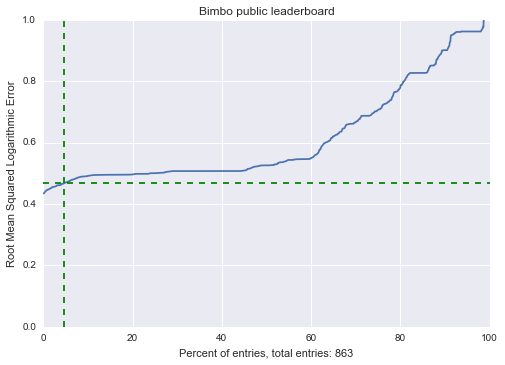

In [7]:
plt.plot(entries['leader-number'].values / len(entries)*100, 
         entries['score'].values)
plt.ylim((0,1))
plt.xlabel('Percent of entries, total entries: %i' %len(entries))
plt.ylabel('Root Mean Squared Logarithmic Error')
plt.axhline(entries.loc[entries['team_name'] == 'Kasper Van Lombeek','score'].values, color='green', ls='dashed')
plt.axvline(entries.loc[entries['team_name'] == 'Kasper Van Lombeek','leader-number'].values / \
            len(entries)*100, color='green', ls='dashed')
plt.title('Bimbo public leaderboard')